# DiT

The implementations of DiT.

Written by [Junkun Yuan](https://junkunyuan.github.io/) (yuanjk0921@outlook.com).

See paper reading list and notes [here](https://junkunyuan.github.io/paper_reading_list/paper_reading_list.html).

Last updated on Jul 12, 2025; &nbsp; First committed on Mar 10, 2025.

**References**
- [**Scalable Diffusion Models with Transformers** *(ICCV 2023)*](https://arxiv.org/pdf/2212.09748)

**Contents**
- Model Structure
    - Model Configurations
    - Patch Embedding
    - Postion Embedding
    - Timestep Embedding
    - Attention Module
    - MLP Module
    - DiT Block
    - Output Layer
    - DiT

## Model Structure

### Model Configurations

| Model | Parameters | GPU memory | depth | hidden_size | patch_size | num_heads |
| --- | --- | --- | --- | --- | --- | --- |
| DiT-S/8 | 33M | 12.8G | 12 | 384 | 8 | 6 |
| DiT-S/4 | 33M | 12.8G | 12 | 384 | 4 | 6 |
| **DiT-S/2** | **33M** | **14.8G** | **12** | **384** | **2** | **6** |
| DiT-B/8 | 131M | 14.1G | 12 | 768 | 8 | 12 |
| DiT-B/4 | 131M | 14.1G | 12 | 768 | 4 | 12 |
| **DiT-B/2** | **131M** | **19.2G** | **12** | **768** | **2** | **12** |
| DiT-L/8 | 458M | 22.6G | 24 | 1024 | 8 | 16 |
| DiT-L/4 | 458M | 23.9G | 24 | 1024 | 4 | 16 |
| **DiT-L/2** | **458M** | **30.4G** | **24** | **1024** | **2** | **16** |
| DiT-XL/8 | 675M | 29.6G | 28 | 1152 | 8 | 16 |
| DiT-XL/4 | 675M | 29.6G | 28 | 1152 | 4 | 16 |
| **DiT-XL/2** | **675M** | **40.7G** | **28** | **1152** | **2** | **16** |

### Patch Embedding

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of image patch embedding
## Modified from timm: https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/patch_embed.py
## --------------------------------------------------------------------------------
import torch.nn as nn

class PatchEmbed(nn.Module):
    def __init__(self, patch_size, in_chans, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # shape: (B, C, H, W) => (B, D, H/P, W/P)
        x = x.flatten(2).transpose(1, 2)  # shape: (B, HW/P^2, D)
        return x

### Position Embeddings

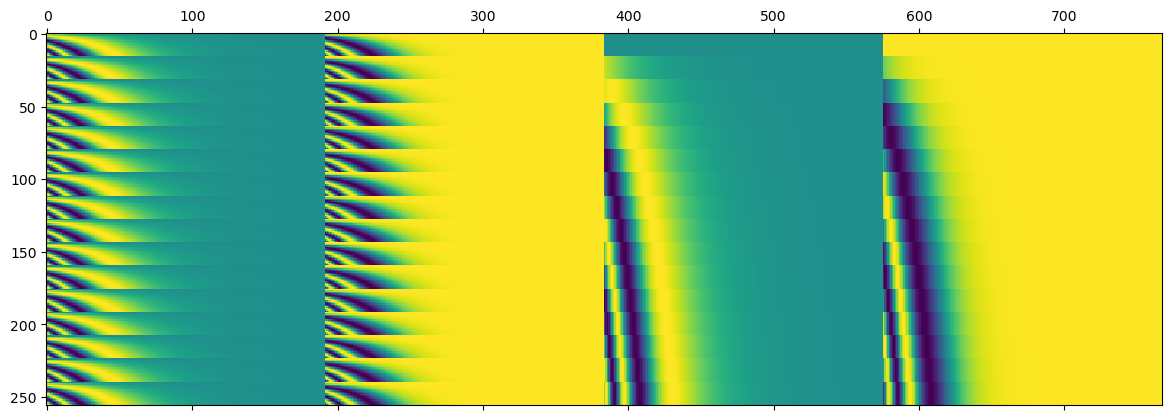

In [ ]:
## --------------------------------------------------------------------------------
# Simple implementation of position embedding
# Modified from MAE: https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py
## --------------------------------------------------------------------------------
import numpy as np

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size)  # shape: (grid_size,)
    grid_w = np.arange(grid_size, dtype=np.float64)  # shape: (grid_size,)
    grid = np.stack(np.meshgrid(grid_w, grid_h), axis=0)  # shape: (2, grid_size, grid_size)
    grid = grid.reshape([2, 1, grid_size, grid_size])  # shape: (2, 1, grid_size, grid_size)
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # shape: (grid_size**2, embed_dim)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (grid_size**2, embed_dim/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (grid_size**2, embed_dim/2)
    emb = np.concatenate([emb_h, emb_w], axis=1) # (grid_size**2, embed_dim)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # shape: (embed_dim/2, )

    pos = pos.reshape(-1)  # (grid_size**2,)

    out = np.einsum('m,d->md', pos, omega)  # (grid_size**2, embed_dim/2)

    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (grid_size**2, embed_dim)
    return emb

import matplotlib.pyplot as plt
_ = plt.matshow(get_2d_sincos_pos_embed(embed_dim=768, grid_size=16))

### Timestep Embedding

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of timestep embedding
## Modified from DiT: https://github.com/facebookresearch/DiT/blob/main/models.py
## --------------------------------------------------------------------------------
import math
import torch

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        ## Borrowed from from https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)  # [dim // 2]
        args = t[:, None].float() * freqs[None]  # [B, dim // 2]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding  # [B, dim]

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)  # [B, dim]
        t_emb = self.mlp(t_freq)  # [B, hidden_size]
        return t_emb

### Label Embedding

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of label embedding
## Modified from DiT: https://github.com/facebookresearch/DiT/blob/main/models.py
## --------------------------------------------------------------------------------

class LabelEmbedder(nn.Module):
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels):
        """Drops labels to enable classifier-free guidance."""
        drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train):
        use_dropout = self.dropout_prob > 0
        if train and use_dropout:
            labels = self.token_drop(labels)
        embeddings = self.embedding_table(labels)  # [B, hidden_size]
        return embeddings


### Attention Module

In [ ]:
## --------------------------------------------------------------------------------
# Simple implementation of multi-head self-attention
# Modified from timm: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
## --------------------------------------------------------------------------------

class Attention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__(hidden_size, num_heads)
        self.head_dim = hidden_size // num_heads
        self.qkv = nn.Linear(hidden_size, hidden_size * 3)
        self.proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        B, N, C = x.shape
        # 1st computation complexity: N * C * 3C = 3N(C^2)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)  # shape: (3, B, heads, N, head_dim)
        q, k, v = qkv.unbind(0)  # shape: (B, heads, N, head_dim)

        q = q * (self.head_dim ** -0.5)
        # 2nd computation complexity: N * C * N = C(N^2)
        attn = q @ k.transpose(-2, -1)  # shape: (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        # 3rd computation complexity: N * N * C = C(N^2)
        x = attn @ v  # shape: (B, heads, N, head_dim)

        x = x.transpose(1, 2).reshape(B, N, C)  # shape: (B, N, dim)
        
        # 4th computation complexity: N * C * C = N(C^2)
        x = self.proj(x)

        # total computation complexity: 3N(C^2) + C(N^2) + C(N^2) + N(C^2) = 4N(C^2) + 2C(N^2)
        return x

### MLP Module

In [ ]:
## --------------------------------------------------------------------------------
# Simple implementation of MLP layer
# Modified from timm: https://github.com/huggingface/pytorch-image-models/blob/main/timm/layers/mlp.py
## --------------------------------------------------------------------------------

class Mlp(nn.Module):
    def __init__(self):
        super().__init__(in_features, hidden_features, act_layer, out_features=None)
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.drop1(self.act(self.fc1(x)))
        x = self.drop2(self.fc2(x))
        return x

### DiT Block

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of DiT block
## Modified from DiT: https://github.com/facebookresearch/DiT/blob/main/models.py
## --------------------------------------------------------------------------------

class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size)
        )

        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, **block_kwargs)
        
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu)

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)

        ## Attention
        x = self.norm1(x) * (1 + scale_msa.unsqueeze(1)) + shift_msa.unsqueeze(1)
        x = x + gate_msa.unsqueeze(1) * self.attn(x)

        ## MLP
        x = self.norm2(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(x)
        return x

### Output Layer

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of output layer
## Modified from DiT: https://github.com/facebookresearch/DiT/blob/main/models.py
## --------------------------------------------------------------------------------

class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size)
        )
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels)

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)  # [B, D]
        x = self.norm_final(x) * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)  # [B, N, D]
        x = self.linear(x)  # [B, N, patch_size * patch_size * out_channels]
        return x

### DiT

In [ ]:
## --------------------------------------------------------------------------------
## Simple implementation of DiT.
## Modified from https://github.com/facebookresearch/DiT/blob/main/models.py
## --------------------------------------------------------------------------------

class DiT(nn.Module):
    def __init__(self, input_size=32, patch_size=2, in_channels=4, hidden_size=1152, depth=28, num_heads=16, class_dropout_prob=0.1, num_classes=1000):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels * 2
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(img_size=input_size, patch_size=patch_size, in_chans=in_channels, embed_dim=hidden_size)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=4.0) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))  # [B, H/P, W/P, P, P, out_channels]
        x = torch.einsum('nhwpqc->nchpwq', x)  # [B, out_channels, H/P, P, W/P, P]
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))  # [B, out_channels, H, W]
        return imgs

    def forward(self, x, t, y):
        ## x: images or VAE latents with shape [B, C, H, W]
        ## t: timesteps with shape [B,]
        ## y: labels with shape [B,]
        x = self.x_embedder(x) + self.pos_embed  # [B, L, D], where L = H * W / patch_size ** 2
        t = self.t_embedder(t)  # (B, D)
        y = self.y_embedder(y, self.training)  # (B, D)
        c = t + y  # (B, D)
        for block in self.blocks:
            x = block(x, c)  # (B, L, D)
        x = self.final_layer(x, c)  # (B, L, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)  # (B, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        ## Borrowed from https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        
        half = x[: len(x) // 2]  # [B/2, C, H, W]
        combined = torch.cat([half, half], dim=0)  # [B, C, H, W]
        model_out = self.forward(combined, t, y)  # [B, C * 2, H, W]
        eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]  # [B, C, H, W]

        ## Apply CFG
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)  # [B/2, C, H, W]
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)  # [B/2, C, H, W]
        
        eps = torch.cat([half_eps, half_eps], dim=0)  # [B, C, H, W]
        return torch.cat([eps, rest], dim=1)  # [B, C * 2, H, W]